In [8]:
import numpy as np
from matplotlib import pyplot as plt
from py import opt, read

from py.utils import *
import matplotlib.patches as patches

from scipy.stats import rankdata

from py.community import *

import networkx as nx

from scipy.linalg import eigh

from hypergraph import hypergraph

data = 'contact-high-school'
path = data + '/' + data + '-'

In [9]:
# t_min = 1386230122
t_min = 0

C = read.read_data(data, t_min = t_min, prefix='data/')
C = hypergraph.hypergraph(C)
G = hypergraph.projected_graph(C, as_hyper = True)
n = G.n
d = G.node_degrees()
# d_ = np.sort(d)

In [10]:
b, obj = opt.compute_b(d, tol = 10**(-10))

Round 10: MSE = 1486.290532676355
Round 20: MSE = 0.003045556577029551
Round 30: MSE = 4.948204508609423e-09
Successfully converged within tolerance 1e-10 in 33 rounds.


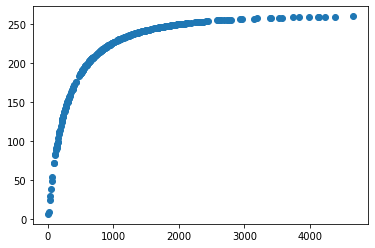

In [11]:
plt.scatter(d, b)

In [13]:
b.sum() - b.max()**2

232.90614998718956

In [12]:
A = adjacency_matrix(G)

W = W_from_b(b)
B = A - W

W_NG = np.outer(d, d)/d.sum()
np.fill_diagonal(W_NG, 0)
B_NG = A - W_NG

In [135]:
# mean relative error of W

rel_err = np.abs((W_NG - W) / W)
np.nanmean(rel_err)

# relative error of B

rel_err = np.abs((B_NG - B) / B)
np.nanmean(rel_err)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


0.21744208983800545

# Direct Modularity Comparisons

In [136]:
k = 10

def compare_modularities(k):

    ell1, Q1 = find_best_clustering(A, W, k, n_reps = 50) 
    ell2, Q2 = find_best_clustering(A, W_NG, k, n_reps = 50) 

    Z1 = one_hot(ell1)
    Z2 = one_hot(ell2)

    straight1 = modularity(A, W, Z1)
    straight2 = modularity(A, W_NG, Z2)
    cross1 = modularity(A, W, Z2)
    cross2 = modularity(A, W_NG, Z1)
    
    return(np.array([straight1, cross2, cross1, straight2]))

In [137]:
def modularity_suite(k, A, W, n_reps = 50, n_rounds = 100, cross = None):
    Q = [find_best_clustering(A, W, k, n_reps)[1] for i in range(n_rounds)]
    return(Q)

In [138]:
k_min = 2
k_max = 11

n_rounds = 100

v = np.array([modularity_suite(k, A, W, n_reps = 50, n_rounds = 100) for k in range(k_min, k_max)])
v_NG = np.array([modularity_suite(k, A, W_NG, n_reps = 50, n_rounds = 100) for k in range(k_min, k_max)])

# Modularity Example

In [139]:
k = 8

num_unique1 = 1
num_unique2 = 2
# while num_unique1 != num_unique2:
#     print('trying')
ell1, Q1 = find_best_clustering(A, W, k, 500)
num_unique1 = len(np.unique(ell1))
ell2, Q2 = find_best_clustering(A, W_NG, k, 500)
num_unique2 = len(np.unique(ell2))

sig1 = np.sqrt(np.var(one_hot(ell1).sum(axis = 0)))
sig2 = np.sqrt(np.var(one_hot(ell2).sum(axis = 0)))

In [140]:
def reorder_labels(x):
    counts = np.bincount(x)
    lookup = np.argsort(np.argsort(-counts))
    return(np.array([lookup[i] for i in x]).astype(int))

In [141]:
ell1 = reorder_labels(ell1.astype(int))
ell2 = reorder_labels(ell2.astype(int))

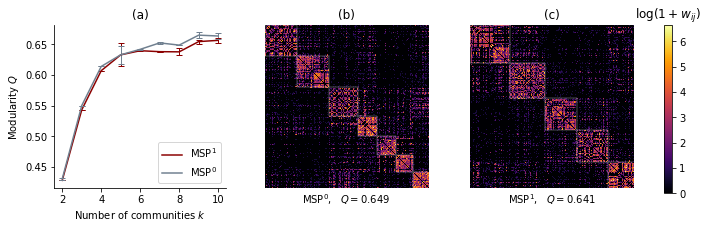

In [142]:
fig = plt.figure(figsize = (12, 3))


ax3 = fig.add_subplot(131)

x_axis = np.arange(k_min, k_max)

sig_mul = 2

sig = np.sqrt(np.var(v, axis = 1))
mu = v.mean(axis = 1)
ax3.plot(x_axis, mu, label = '$\mathrm{MSP}^1$', color = 'darkred')
ax3.errorbar(x_axis, mu, yerr = sig_mul*sig, fmt = 'none', color = 'darkred', elinewidth=1, capsize = 3)
# ax3.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .4, color = 'darkred')


sig = np.sqrt(np.var(v_NG, axis = 1))
mu = v_NG.mean(axis = 1)
ax3.plot(x_axis, mu, label = '$\mathrm{MSP}^0$', color = 'slategrey')
ax3.errorbar(x_axis, mu, yerr = sig_mul*sig, fmt = 'none', color = 'slategrey', elinewidth=1, capsize = 3)

# plt.fill_between(x_axis, mu + sig_mul*sig, mu-sig_mul*sig, alpha = .4, color = 'slategrey')


ax3.set(xlabel = r'Number of communities $k$',
       ylabel = r'Modularity $Q$',
       title = '(a)')

ax3.legend(loc = 'lower right')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)


ax = fig.add_subplot(133)

ax.imshow(degree_sort(np.log(1+A), ell1), cmap = 'inferno', 
          interpolation = 'none', aspect = 1)

# nx.draw_networkx_nodes(g, pos = pos, node_color = ell, cmap = 'jet', node_size = 10, ax = ax)
# nx.draw_networkx_edges(g, pos = pos, edge_color = 'grey', alpha = .1, ax = ax)
ax.set(title = '(c)' ,
       xlabel = r'$\mathrm{MSP}^1$, $\;$ $Q = $' + str(round(Q1, 3)))

sig = np.sqrt(np.var(one_hot(ell2).sum(axis = 0)))
ax2 = fig.add_subplot(132)
im = ax2.imshow(degree_sort(np.log(1+A), ell2), 
                cmap = 'inferno', 
                interpolation = 'none', 
                aspect = 1)

title = ax2.set(title = '(b)',
        xlabel = r'$\mathrm{MSP}^{0}$, $\;$ $Q = $' + str(round(Q2, 3)))

ix1 = np.array([0.0,.0])
counter = 0
for i in np.unique(ell1):
    j = (ell1 == i).sum()
    if counter == 0:
        xend,yend = j+1, j-1
    elif counter == len(np.unique(ell1))-1:
        xend, yend = j+5,j+5
    else:
        xend, yend = j,j 
    rect = patches.Rectangle(ix1-.5,xend,yend,linewidth=.3,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
    ix1 += np.array([xend,yend])
    counter += 1

ix2 = np.array([0,0])
counter = 0
for i in np.unique(ell2):
    j = (ell2 == i).sum()
    if counter == 0:
        xend,yend = j+1, j-1
    elif counter == len(np.unique(ell2))-1:
        xend, yend = j+5,j+5
    else:
        xend, yend = j,j 
    rect = patches.Rectangle(ix2-.5,xend,yend,linewidth=.3,edgecolor='w',facecolor='none')
    ax2.add_patch(rect)
    ix2 += np.array([xend,yend])
    counter += 1
# for i in np.unique(ell2):    
#     j = (ell2 == i).sum()
#     rect = patches.Rectangle(ix2,j,j,linewidth=.3,edgecolor='w',facecolor='none')
#     ax2.add_patch(rect)
#     ix2 += np.array([j,j])


for x in [ax, ax2]:
    x.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,
        left=False,
        labelbottom=False,
        labelleft=False,
        length = 0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.1, 0.01, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar_ax.set(title = '$\log (1 + w_{ij})$')
    
for AX in [ax, ax2]:
    for loc in ['top', 'right', 'bottom', 'left']:
        AX.spines[loc].set_visible(False)
    
#     AX.set_aspect(1)
    

plt.savefig('fig/modularity_' + data +  '.pdf',bbox_inches = 'tight')

In [143]:
print(modularity(A, W_NG, one_hot(ell1)), modularity(A, W, one_hot(ell1)))

print(modularity(A, W_NG, one_hot(ell2)), modularity(A, W, one_hot(ell2)))

0.6469081703180837 0.6412829560426657
0.648697224522868 0.6418008667717237


In [128]:
num_unique1

7

In [129]:
num_unique2

6